In [1]:
import os
import numpy as np
import pandas as pd
import pandasai as pai
from dotenv import load_dotenv
from kagglehub import dataset_download
from pandasai_litellm.litellm import LiteLLM
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

pai.config.set({
    'llm' : LiteLLM(
        model = 'gpt-5',
        api_key = api_key),
    'temperature' : 0,
    'seed' : 42})

c:\Users\ccrea\miniconda3\envs\stock-networks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load/match Nasdaq symbols and FDA recalls

In [2]:
nasdaq = pd.read_csv('symbols_valid_meta.csv')
nasdaq

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
2,Y,AAA,Alternative Access First Priority CLO Bond ETF,P,,Y,100.0,N,NaN,AAA,AAA,N
3,Y,AAAU,Goldman Sachs Physical Gold ETF Shares,Z,,Y,100.0,N,NaN,AAAU,AAAU,N
4,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,S,N,100.0,N,N,NaN,AACG,N
...,...,...,...,...,...,...,...,...,...,...,...,...
8140,Y,ZVOL,Volatility Premium Plus ETF,Z,,Y,100.0,N,NaN,ZVOL,ZVOL,N
8141,Y,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,ZVRA,N
8142,Y,ZWS,Zurn Elkay Water Solutions Corporation Common ...,N,,N,100.0,N,NaN,ZWS,ZWS,N
8143,Y,ZYME,Zymeworks Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZYME,N


In [3]:
nasdaq_stocks = nasdaq.loc[nasdaq.ETF == 'N'].copy()
nasdaq_stocks

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
4,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,S,N,100.0,N,N,NaN,AACG,N
6,Y,AAL,"American Airlines Group, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,AAL,N
7,Y,AAME,Atlantic American Corporation - Common Stock,Q,G,N,100.0,N,N,NaN,AAME,N
...,...,...,...,...,...,...,...,...,...,...,...,...
8139,Y,ZVIA,Zevia PBC Class A Common Stock,N,,N,100.0,N,NaN,ZVIA,ZVIA,N
8141,Y,ZVRA,"Zevra Therapeutics, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,ZVRA,N
8142,Y,ZWS,Zurn Elkay Water Solutions Corporation Common ...,N,,N,100.0,N,NaN,ZWS,ZWS,N
8143,Y,ZYME,Zymeworks Inc. - Common Stock,Q,Q,N,100.0,N,N,NaN,ZYME,N


In [4]:
nasdaq_stocks_llm = pai.DataFrame(nasdaq_stocks[['Symbol', 'Security Name']])
nasdaq_stocks_llm

,Symbol,Security Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Corporation Common Stock
4,AACG,ATA Creativity Global - American Depositary Sh...
6,AAL,"American Airlines Group, Inc. - Common Stock"
7,AAME,Atlantic American Corporation - Common Stock
...,...,...
8139,ZVIA,Zevia PBC Class A Common Stock
8141,ZVRA,"Zevra Therapeutics, Inc. - Common Stock"
8142,ZWS,Zurn Elkay Water Solutions Corporation Common ...
8143,ZYME,Zymeworks Inc. - Common Stock


In [5]:
recalls_pth = dataset_download('mexwell/fda-product-recalls')
recalls = pd.read_csv(os.path.join(recalls_pth, 'fda_product_recalls.csv'))
recalls['center_classification_date'] = pd.to_datetime(recalls.center_classification_date)
recalls

,fei_number,recalling_firm_name,product_type,product_classification,status,distribution_pattern,recalling_firm_city,recalling_firm_state,recalling_firm_country,center_classification_date,reason_for_recall,product_description,event_id,event_classification,product_id,center,recall_details
0,3.002602e+09,Lamb Weston Sales,Food/Cosmetics,Class I,Ongoing,"Distributed in CA, IA, IL, KS, LA MO, MS, NM, ...",Kennewick,Washington,United States,2023-04-21,Undeclared Wheat in foodservice item Hashbrown...,"G5300 Lamb's Supreme Hash Brown Patties, Froze...",92014,Class I,199418,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
1,3.012438e+09,Fresh Express Incorpated,Food/Cosmetics,Class I,Ongoing,Product was shipped to the following states: F...,Windermere,Florida,United States,2023-04-21,The firm was notified by one of their customer...,Fresh EXPRESS Chopped Kit Caesar Romaine Lettu...,92068,Class I,199573,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
2,3.012438e+09,Fresh Express Incorpated,Food/Cosmetics,Class I,Ongoing,Product was shipped to the following states: F...,Windermere,Florida,United States,2023-04-21,The firm was notified by one of their customer...,Fresh Express Chopped Kit Chipotle Cheddar TOT...,92068,Class I,199574,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
3,3.012438e+09,Fresh Express Incorpated,Food/Cosmetics,Class I,Ongoing,Product was shipped to the following states: F...,Windermere,Florida,United States,2023-04-21,The firm was notified by one of their customer...,PREMIUM MAKOTO HONEY GINGER SALAD KIT TOTAL NE...,92068,Class I,199575,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
4,1.000222e+09,"Blood Bank Computer Systems, Inc",Biologics,Class II,Terminated,"GA, DE, TX, MO, PA, CA, FL, KY, IA, MI, IL, an...",Auburn,Washington,United States,2023-04-21,Blood Bank Computer Systems has discovered in ...,"ABO Wheels, Version 1.1.0",91219,Class II,197268,CBER,https://www.accessdata.fda.gov/scripts/ires/?P...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83150,3.004404e+09,Panera Bread LLC,Food/Cosmetics,Class II,Terminated,Nationwide,Saint Louis,Missouri,United States,2012-06-08,Product ingredient statement reversed for Red...,"Panera ,HAZELNUT CREAM CHEESE SPREAD Reduced F...",61831,Class II,109200,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
83151,3.004162e+09,"DSM Nutritional Products, Inc.",Food/Cosmetics,Class II,Terminated,"NJ, WI, IL",Parsippany,New Jersey,United States,2012-06-08,Flavor is contaminated with Salmonella,GB Select Roast Meat Type Flavor Net Wt. 55 lb...,61936,Class II,109523,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
83152,3.002727e+09,Best West Foods,Food/Cosmetics,Class II,Terminated,NV only.,Las Vegas,Nevada,United States,2012-06-08,Soy was not included in the ingredient stateme...,"Florentine Lasagna Rolls;\r\nPerishable, keep ...",61968,Class II,109609,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...
83153,3.002727e+09,Best West Foods,Food/Cosmetics,Class II,Terminated,NV only.,Las Vegas,Nevada,United States,2012-06-08,Soy was not included in the ingredient stateme...,"Cheese Lasagna Rolls;\r\nPerishable, keep froz...",61968,Class II,109610,CFSAN,https://www.accessdata.fda.gov/scripts/ires/?P...


In [6]:
recalls_llm = pai.DataFrame(recalls[[
    'recalling_firm_name',
    'product_type',
    'recalling_firm_city',
    'recalling_firm_state',
    'recalling_firm_country']
    ].drop_duplicates())
recalls_llm

,recalling_firm_name,product_type,recalling_firm_city,recalling_firm_state,recalling_firm_country
0,Lamb Weston Sales,Food/Cosmetics,Kennewick,Washington,United States
1,Fresh Express Incorpated,Food/Cosmetics,Windermere,Florida,United States
4,"Blood Bank Computer Systems, Inc",Biologics,Auburn,Washington,United States
5,The American National Red Cross - Southern Region,Biologics,Douglasville,Georgia,United States
7,Versiti Michigan Inc,Biologics,Grand Rapids,Michigan,United States
...,...,...,...,...,...
83146,General Electric Med Systems LLC,Devices,Waukesha,Wisconsin,United States
83149,Panera Bread LLC,Food/Cosmetics,Saint Louis,Missouri,United States
83151,"DSM Nutritional Products, Inc.",Food/Cosmetics,Parsippany,New Jersey,United States
83152,Best West Foods,Food/Cosmetics,Las Vegas,Nevada,United States


In [7]:
# prompt = """
# Match company names in df2 with Nasdaq ticker symbols from df1.
# For some companies, df2 already has the stock symbol as its name.
# Each unique company name has only a single matching stock symbol.
# The companies represent FDA-recalled products such as food and medical devices.
# Return a DataFrame with columns: ["recalling_firm_name","Security Name","Symbol"].
# Only include rows where you are confident in the match. Skip all others.
# Maximize the total matches that you return within tolearble error limits.
# """
# results = pai.chat(prompt, nasdaq_stocks_llm, recalls_llm)
# results = results.value.copy()
# results.to_csv('recalls_symbol_match.csv')
results = pd.read_csv('recalls_symbol_match.csv', index_col = 0)
results

,recalling_firm_name,Security Name,Symbol
0,3M Company - Health Care Business,3M Company Common Stock,MMM
1,"ANI Pharmaceuticals, Inc.","ANI Pharmaceuticals, Inc. - Common Stock",ANIP
2,AbbVie Inc,AbbVie Inc. Common Stock,ABBV
3,AbbVie Inc.,AbbVie Inc. Common Stock,ABBV
4,Abbott Laboratories,Abbott Laboratories Common Stock,ABT
...,...,...,...
113,Walmart Inc,Walmart Inc. Common Stock,WMT
114,Whirlpool Corporation,Whirlpool Corporation Common Stock,WHR
115,Zoetis Inc,Zoetis Inc. Class A Common Stock,ZTS
116,"Zoetis, LLC",Zoetis Inc. Class A Common Stock,ZTS


In [8]:
print(results.recalling_firm_name.isin(recalls.recalling_firm_name).sum() == results.shape[0])
print(results.Symbol.isin(nasdaq_stocks.Symbol).sum() == results.shape[0])

True
True


## Preprocess training data for DELAY

In [9]:
start_date = '2012-06-08'
end_date = '2023-04-21'
ix_date = pd.date_range(start = start_date, end = end_date, freq = 'D')
col_names = results.Symbol.sort_values().unique()
X = pd.DataFrame(0., index = ix_date, columns = col_names)
for col in X.columns:
    X_col = pd.read_csv(os.path.join('stocks', f'{col}.csv'), header = [0, 1, 2])
    X.loc[X_col.iloc[:, 0].values, col] = X_col.iloc[:, 1].values
X = np.log1p(X.loc[X.sum(1) > 0])
X.T.to_csv('NormalizedData.csv'); X

,A,ABBV,ABT,ACI,ALKS,AMPH,AMRX,AMZN,ANGO,ANIP,...,TFX,TGT,TMO,TRIB,TSN,UNFI,VTRS,WHR,WMT,ZTS
2012-06-08,3.268574,0.000000,3.175169,0.000000,2.796671,0.000000,0.000000,2.478553,2.595255,2.794839,...,3.998936,3.725932,3.899300,4.023189,2.743152,3.964615,2.934904,3.679485,2.912506,0.000000
2012-06-11,3.253399,0.000000,3.169423,0.000000,2.818398,0.000000,0.000000,2.470216,2.558777,2.718660,...,3.994153,3.717655,3.876903,4.020590,2.732784,3.930059,2.915382,3.646911,2.902895,0.000000
2012-06-12,3.265411,0.000000,3.176407,0.000000,2.826722,0.000000,0.000000,2.469878,2.569554,2.674149,...,3.997619,3.708639,3.888456,4.011877,2.736252,3.948741,2.910891,3.659578,2.905551,0.000000
2012-06-13,3.253892,0.000000,3.169423,0.000000,2.826129,0.000000,0.000000,2.462704,2.561868,2.618855,...,3.989347,3.706792,3.882190,4.005732,2.729304,3.931237,2.904118,3.637096,2.896436,0.000000
2012-06-14,3.262483,0.000000,3.179187,0.000000,2.833801,0.000000,0.000000,2.461510,2.574138,2.706716,...,3.988017,3.715159,3.897395,4.018854,2.727310,3.940222,2.911791,3.633746,2.904294,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14,4.926438,5.007698,4.609613,3.017408,3.412797,3.764682,0.858662,4.639668,2.311545,3.674273,...,5.560272,5.002677,6.373238,1.648659,4.037893,3.284289,2.282392,4.756214,3.892001,5.142046
2023-04-17,4.933474,5.005175,4.614932,3.016948,3.415758,3.760269,0.974560,4.641888,2.310553,3.681351,...,5.548192,5.013111,6.372831,1.667707,4.047857,3.312730,2.286024,4.771017,3.898839,5.142160
2023-04-18,4.925011,4.995328,4.611421,3.020162,3.409496,3.777577,0.970779,4.637637,2.280339,3.663305,...,5.544517,5.011277,6.366468,1.667707,4.038700,3.290638,2.283301,4.789733,3.900999,5.141191
2023-04-19,4.924510,5.005360,4.685953,3.027470,3.411148,3.789177,1.007958,4.656813,2.296567,3.695358,...,5.577714,5.011950,6.358000,1.713798,4.050731,3.303952,2.278746,4.789378,3.902045,5.144207


In [10]:
t = np.arange(X.shape[0]) / (X.shape[0] - 1)
t = pd.Series(t, index = X.index, name = 'PseudoTime')
t.to_csv('PseudoTime.csv'); t

2012-06-08    0.000000
2012-06-11    0.000366
2012-06-12    0.000732
2012-06-13    0.001098
2012-06-14    0.001464
                ...   
2023-04-14    0.998536
2023-04-17    0.998902
2023-04-18    0.999268
2023-04-19    0.999634
2023-04-20    1.000000
Name: PseudoTime, Length: 2734, dtype: float64

In [11]:
tf = pd.Series(X.columns).to_csv(
    'TranscriptionFactors.csv',
    index = False, header = False)

In [12]:
np.random.seed(1)
split = pd.Series(1, index = X.columns, name = 'Split')
split.loc[split.sample(frac = .2).index] = 2
split.to_csv('splitLabels.csv'); split

A       1
ABBV    1
ABT     1
ACI     1
ALKS    1
       ..
UNFI    1
VTRS    1
WHR     1
WMT     1
ZTS     2
Name: Split, Length: 101, dtype: int64

## Construct groud-truth network from recalls

In [119]:
events = recalls[['recalling_firm_name', 'center_classification_date']].copy()
symbol_dict = results.set_index('recalling_firm_name').Symbol.to_dict()
events['Symbol'] = events.recalling_firm_name.map(symbol_dict)
events = (events.loc[~events.Symbol.isna()].drop_duplicates()
          .sort_values('center_classification_date'))
events = pd.merge_asof(
    events, pd.Series(X.index, name = 'date'),
    left_on = 'center_classification_date',
    right_on = 'date', direction = 'forward')
events

,recalling_firm_name,center_classification_date,Symbol,date
0,Becton Dickinson and Company,2012-06-15,BDX,2012-06-15
1,Abbott Laboratories,2012-06-18,ABT,2012-06-18
2,Boston Scientific Corporation,2012-06-21,BSX,2012-06-21
3,Abbott Laboratories,2012-06-28,ABT,2012-06-28
4,"Edwards Lifesciences, LLC",2012-07-09,EW,2012-07-09
...,...,...,...,...
876,"Bio-Rad Laboratories, Inc.",2023-04-12,BIO,2023-04-12
877,"Edwards Lifesciences, LLC",2023-04-12,EW,2023-04-12
878,"Angiodynamics, Inc.",2023-04-12,ANGO,2023-04-12
879,Boston Scientific Corporation,2023-04-18,BSX,2023-04-18


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


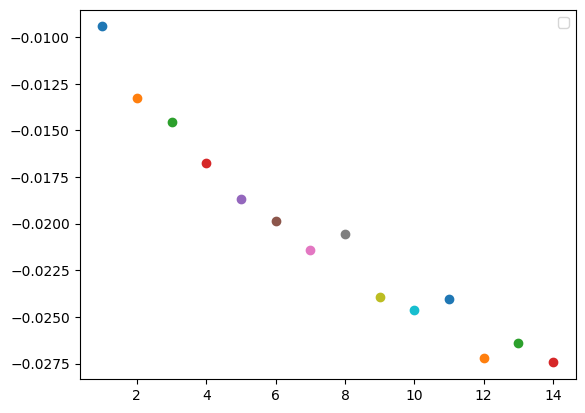

In [ ]:
# plt.figure()
# for N in range(1, 15):
#     day0 = X.values[X.index.get_indexer(events.date), X.columns.get_indexer(events.Symbol)]
#     ixN = X.index.get_indexer(events.date) + N
#     valid = ixN < X.shape[0]
#     day0 = day0[valid]
#     dayN = X.values[ixN[valid], X.columns.get_indexer(events.Symbol)[valid]]
#     events.loc[valid, f'change_{N}'] = dayN - day0
#     plt.scatter([N], [np.quantile(dayN - day0, .2)])

#     # events.hist(f'change_{N}', bins = np.linspace(-1, 1, 50), alpha = .25, ax = plt.gca(), label = N)
# # plt.yscale('log')
# plt.legend()
# plt.show()